# Single-shot autofocus using deep learning
This notebook provides all code neccessary for training single-shot autofocus with deep learning architectures, and shows the production of all figures in the corresponding paper

## Imports and preliminaries
Run these cells before going into any of the other sections. Subsequent numbered sections can be run independently, with all cells in order (i.e. section 4 can run without running section 1, but sections 2a, 2b, and 2c must be run in order)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from util.afutil import get_patch_metadata, read_or_calc_focal_planes, compile_deterministic_data,get_led_na, get_led_nas, \
feature_vector_generator_fn, MagellanWithAnnotation, plot_results,  HDFDataWrapper, get_led_angle
from util.defocusnetwork import DefocusNetwork
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
#editable text in fonts
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#make text on figures look good
SMALL_SIZE = 16
MEDIUM_SIZE = 22
BIGGER_SIZE = 28
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#for one GPU training
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from PIL import Image
def savetiff(path, array):
    im2 = Image.fromarray(array)
    im2.save(path, compression="tiff_deflate", save_all=True)

/home/henry/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The DataWrapper class wraps all the essential functionality needed for training single shot autofocus. By default, it reads Micro-Magellan datasets (with an added subclass to be able to store the results of intermediate computations in an HDF5 file), but this could be replaced with any data source so long as it provides the following methods and fields

In [2]:
class DataWrapper:

    def __init__(self, magellan):
        self.magellan = magellan

    def read_ground_truth_image(self, position_index, z_index):
        """
        Read image in which focus quality can be measured form quality of image
        :param pos_index: index of xy position
        :param z_index: index of z slice (starting at 0)
        :param xy_slice: (cropped region of image)
        :return:
        """
        return self.magellan.read_image(channel_name='DPC_Bottom', pos_index=position_index, 
                        z_index=z_index + min(self.magellan.get_z_slices_at(position_index))).astype(np.float)

    def read_prediction_image(self, position_index, z_index, patch_index, split_k):
        """
        Read image used for single shot prediction (i.e. single LED image)
        :param pos_index: index of xy position
        :param z_index: index of z slice (starting at 0)
        :param split_k: number of crops along each dimension
        :param patch_index: index of the crop
        :return:
        """
        patch_size, patches_per_image = get_patch_metadata((self.get_image_width(),
                                                            self.get_image_height()), split_k)
        y_tile_index = patch_index // split_k
        x_tile_index = patch_index % split_k
        xy_slice = [[y_tile_index * patch_size, (y_tile_index + 1) * patch_size],
                    [x_tile_index * patch_size, (x_tile_index + 1) * patch_size]]
        image = self.magellan.read_image(channel_name='autofocus', pos_index=position_index, z_index=z_index +
                  min(self.magellan.get_z_slices_at(position_index))).astype(np.float)
        #crop
        return image[xy_slice[0][0]:xy_slice[0][1], xy_slice[1][0]:xy_slice[1][1]]
        
    def get_image_width(self):
        """
        :return: image width in pixels
        """
        return self.magellan.image_width

    def get_image_height(self):
        """
        :return: image height in pixels
        """
        return self.magellan.image_height

    def get_num_z_slices_at(self, position_index):
        """
        return number of z slices (i.e. focal planes) at the given XY position
        :param position_index:
        :return:
        """
        return len(self.magellan.get_z_slices_at(position_index))

    def get_pixel_size_z_um(self):
        """
        :return: distance in um between consecutive z slices
        """
        return self.magellan.pixel_size_z_um

    def get_num_xy_positions(self):
        """
        :return: total number of xy positons in data set
        """
        return self.magellan.get_num_xy_positions()

    def store_focal_plane(self, name, focal_position):
        """
        Store the computed focal plane as a string, float pair
        """
        self.magellan.write_annotation(name, focal_position)

    def read_focal_plane(self, name):
        """
        read a previously computed focal plane
        :param name: key corresponding to an xy position for whch focal plane has already been computed
        :return:
        """
        return self.magellan.read_annotation(name)

    def store_array(self, name, array):
        """
        Store a numpy array containing the design matrix for training the non-deterministic part of the network (i.e.
        after the Fourier transform) so that it can be retrained quickly without having to recompute
        :param name:
        :param array: (n examples) x (d feature length) numpy array
        """
        self.magellan.store_array(name, array)

    def read_array(self, name):
        """
        Read and return a previously computed array
        :param name:
        :return:
        """
        return self.magellan.read_array(name)

## 1) Explanation of how to use different parts of single shot autofocus library
This section shows netwrok training with a relatively small (~200GB) amount of data to facilitate being able to easily run or modify the code. As a result, it has suboptimal performance. Section 2 shows a much better performing netwrok trained with more data

### Load data and compute the ground truth focal planes as targets for training
The show_output flag will create a plot of the averaged high frequency content of the log power spectrum. If new data is substituted in, the maximum of the this plot should correspond to the correct focal plane

In [3]:
#parameters for the deterministic part of the network
deterministic_params = {'non_led_width': 0.1, 'led_width': 0.6, 'tile_split_k': 2}

#load data
data = DataWrapper(MagellanWithAnnotation(
    '/media/hugespace/henry/data/deepaf2/2018-9-27 Cells and histology af data/Neomounted cells 12x12 30um range 1um step_1'))

#load or compute target focal planes using 22 CPU cores to speed computation
focal_planes = {dataset: read_or_calc_focal_planes(dataset, split_k=deterministic_params['tile_split_k'],
                    n_cores=22, show_output=True) for dataset in [data]}

### Train network using cell data, compute validation on other cell data and tissue section data
The deterministic (i.e. Fourier Transform) beginning part of the network is precomputed and stored, so that it doesn't have to be recomputed on each training iteration

In [6]:
#split cell data into training and validation sets
num_pos = data.get_num_xy_positions()
train_positions = list(range(int(num_pos * 0.9)))
validation_positions = list(range(max(train_positions) + 1, num_pos))

#Compute or load already computed design matrices
train_features, train_targets = compile_deterministic_data([data], [train_positions], focal_planes,
                                                           deterministic_params=deterministic_params)
validation_features, validation_targets = compile_deterministic_data([data], [validation_positions],
                                                    focal_planes, deterministic_params=deterministic_params)

Now use the precalculated features (i.e. the output of the deterministic part of the network that calculates a feature vector) to train the subsequent layers

In [7]:
#make genenrator function for providing training examples and seperate validation generator for assessing its progress
#stop training once error on validation set stops decreasing
train_generator = feature_vector_generator_fn(train_features, train_targets, mode='all', 
                                        split_k=deterministic_params['tile_split_k'])
val_generator = feature_vector_generator_fn(validation_features, validation_targets, mode='all', 
                                        split_k=deterministic_params['tile_split_k'])


#feed in the dimensions of the cropped input so the inference network knows what to expect
#although the inference network is not explicitly used in this notebook, it is created so that the model tensforflow
#creates could later be used on real data
patch_size, patches_per_image = get_patch_metadata((data.get_image_width(),
                                        data.get_image_height()), deterministic_params['tile_split_k'])

Create network, train it, and test its performance on training and validation set

In [ ]:
with DefocusNetwork(input_shape=train_features.shape[1], train_generator=train_generator,
                             val_generator=val_generator, predict_input_shape=[patch_size, patch_size],
                             deterministic_params=deterministic_params, train_mode='train') as network:
    #run training set and both valdation sets through network to generate predictions
    train_prediction_defocus, train_target_defocus = network.predict(train_generator)
    val_prediction_defocus, val_target_defocus = network.predict(val_generator)

computing normalizations
Building trainable graph...
INFO:tensorflow:Scale of 0 disables regularizer.
Building trainable graph...
INFO:tensorflow:Scale of 0 disables regularizer.
Building deterministic graph...
Building trainable graph...
INFO:tensorflow:Scale of 0 disables regularizer.
Training model...


### Visualize network performance on training set and validation set

In [ ]:
plt.figure(figsize=(14,11))
plot_results(train_prediction_defocus, train_target_defocus, color=[0, 0, 0, 0.5])
plot_results(val_prediction_defocus, val_target_defocus, draw_rect=True, color=[1, 0, 1, 0.5])
plt.legend(['sample thickness','Training set', 'Test set'])
print('Training data RMSE: {}'.format( np.sqrt(np.mean((train_prediction_defocus - train_target_defocus) ** 2))))
print('Validation data RMSE: {}'.format(np.sqrt(np.mean((val_prediction_defocus - val_target_defocus) ** 2))))

## 2a) Train with a lot of data to get performance within the depth of focus of the objetive lens


In [ ]:
deterministic_params = {'non_led_width': 0.1, 'led_width': 0.6, 'tile_split_k': 2}

# load data
train_datasets = [
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-8-1 A bit more pre collection af/300k 7x7 30um range 50ms_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-8-1 A bit more pre collection af/75k 7x7 30um range 50ms_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-7-30 Pre collection autofocus/75k cells 10 ms exposure_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-7-30 Pre collection autofocus/75k cells 50 ms exposure_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-7-30 Pre collection autofocus/75k cells 150 ms exposure_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-7-30 Pre collection autofocus/300k cells 10 ms exposure_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-7-30 Pre collection autofocus/300k cells 50 ms exposure_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-7-30 Pre collection autofocus/300k cells 150 ms exposure_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-8-21 Slide 1-10/slide 1-10 seconds mid acquisition autofocus_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-8-21 Slide 1-10/slide 1-10 third mid acquisition autofocus_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-8-26 Slide set 2 af training/Slide 2-0a 6x6 30um again_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-8-26 Slide set 2 af training/Slide 2-0c 6x6 30um again_1.hdf'),
    HDFDataWrapper('/media/hugespace/henry/data/deepaf2/2018-8-26 Slide set 2 af training/Slide 2-0c 6x6 30um_1.hdf'),
    HDFDataWrapper('/media/hugespace/henry/data/deepaf2/2018-8-26 Slide set 2 af training/Slide 2-0d 6x6 30um_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-8-26 Slide set 2 af training/Slide 2-0d 6x6 30um again_1.hdf'),
]

test_dataset = HDFDataWrapper(
    '/media/hugespace/henry/data/deepaf2/2018-8-26 Slide set 2 af training/Slide 2-0a 6x6 30um_1.hdf')


# load or compute target focal planes using 22 CPU cores to speed computation
focal_planes = {dataset: read_or_calc_focal_planes(dataset, split_k=deterministic_params['tile_split_k'],
                n_cores=8, show_output=True) for dataset in [*train_datasets, test_dataset]}

train_positions = [list(range(int(dataset.get_num_xy_positions() * 0.9))) for dataset in train_datasets]
validation_positions = [list(range(int(dataset.get_num_xy_positions() * 0.9),
                                  dataset.get_num_xy_positions())) for dataset in train_datasets]
# Compute or load already computed design matrices
train_features, train_targets = compile_deterministic_data(train_datasets, train_positions,
                           focal_planes, deterministic_params=deterministic_params)
validation_features, validation_targets = compile_deterministic_data(train_datasets,
                           validation_positions, focal_planes, deterministic_params=deterministic_params)
# test dataset is entirely different acquisition
test_features, test_targets = compile_deterministic_data([test_dataset],
          [list(range(test_dataset.get_num_xy_positions()))], focal_planes, deterministic_params=deterministic_params)

train_generator = feature_vector_generator_fn(train_features, train_targets, mode='all',
                                              split_k=deterministic_params['tile_split_k'])
val_generator = feature_vector_generator_fn(validation_features, validation_targets, mode='all',
                                            split_k=deterministic_params['tile_split_k'])
test_generator = feature_vector_generator_fn(test_features, test_targets, mode='all',
                                             split_k=deterministic_params['tile_split_k'])

# feed in the dimensions of the cropped input so the inference network knows what to expect
# although the inference network is not explicitly used in this notebook, it is created so that the model tensforflow
# creates could later be used on real data
patch_size, patches_per_image = get_patch_metadata((test_dataset.get_image_width(),
                                test_dataset.get_image_height()), deterministic_params['tile_split_k'])

In [4]:
# Create network and train it, or load if a good one already
if not os.path.isdir('models/good_model'):
    with DefocusNetwork(input_shape=train_features.shape[1], train_generator=train_generator,
                        val_generator=val_generator, predict_input_shape=[patch_size, patch_size],
                        deterministic_params=deterministic_params, train_mode='train',
                        learning_rate=2e-5, val_overshoot_steps=1000, 
                        export_path='models/good_model'  ) as network:

        # run training set and both valdation sets through network to generate predictions
        train_prediction_defocus, train_target_defocus = network.predict(train_generator)
        test_prediction_defocus, test_target_defocus = network.predict(test_generator)
else:
    with DefocusNetwork(input_shape=train_features.shape[1], train_generator=train_generator,
                    val_generator=val_generator, predict_input_shape=[patch_size, patch_size],
                    deterministic_params=deterministic_params, train_mode='load',
                       load_model_path='models/good_model') as network:

        # run training set and both valdation sets through network to generate predictions
        train_prediction_defocus, train_target_defocus = network.predict(train_generator)
        test_prediction_defocus, test_target_defocus = network.predict(test_generator)

INFO:tensorflow:Restoring parameters from ./good_model/variables/variables


Training data (cells) RMSE: 1.670188614494956
Validation data (cells) RMSE: 1.3585248389718456


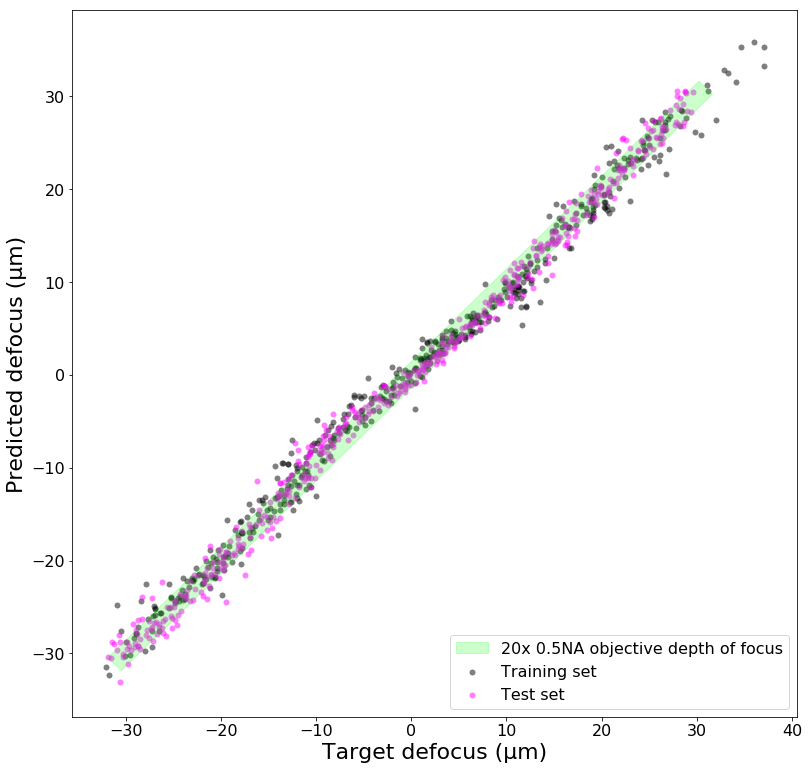

In [44]:
plt.figure(figsize=(13, 13))
plot_results(train_prediction_defocus, train_target_defocus, color=[0, 0, 0, 0.5])
plot_results(test_prediction_defocus, test_target_defocus, draw_rect=True, color=[1, 0, 1, 0.5])
plt.legend(['20x 0.5NA objective depth of focus','Training set', 'Test set'])
print('Training data (cells) RMSE: {}'.format(
    np.sqrt(np.mean((train_prediction_defocus - train_target_defocus) ** 2))))
print('Validation data (cells) RMSE: {}'.format(
    np.sqrt(np.mean((test_prediction_defocus - test_target_defocus) ** 2))))

if not os.path.isdir('figures'):
    os.mkdir('figures')
plt.savefig('figures/good_test_performance.pdf', transparent=True)

## 2b) Performance degrades when switching to a different type of sample
First visualize different types of samples

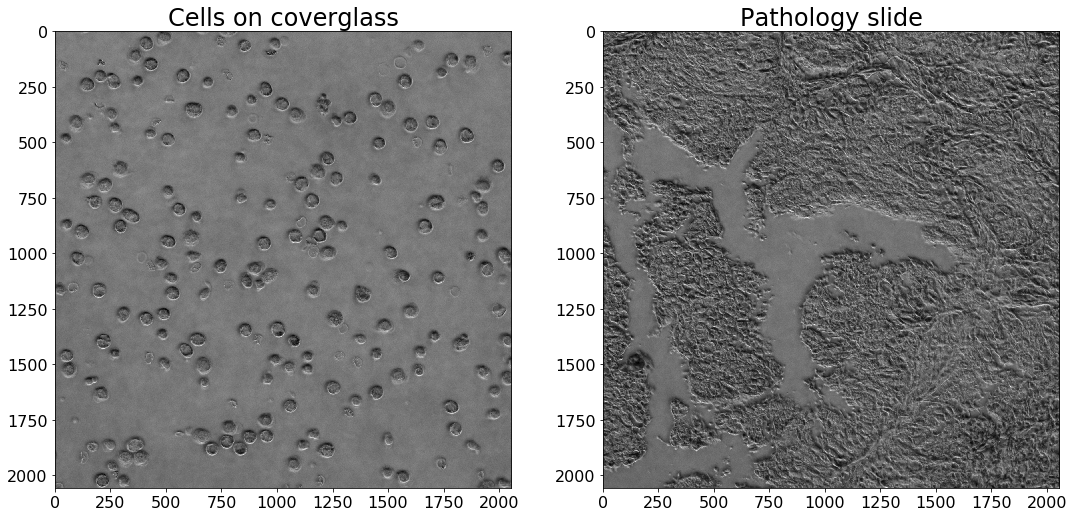

In [10]:
cell_data = HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-8-1 A bit more pre collection af/300k 7x7 30um range 50ms_1.hdf')
    
histology_data = DataWrapper(MagellanWithAnnotation(
    '/media/hugespace/henry/data/deepaf2/2018-9-27 Cells and histology af data/unstained path section 12x12 30um range 1um step_1'))

plt.figure(figsize=(18, 9))
plt.subplot(121)
plt.imshow(cell_data.read_ground_truth_image(0,30),cmap='gray')
plt.title('Cells on coverglass', fontsize=24)
plt.subplot(122)
plt.imshow(histology_data.read_ground_truth_image(0,29),cmap='gray')
plt.title('Pathology slide', fontsize=24)

savetiff('figures/cells.tif', cell_data.read_ground_truth_image(0,30))
savetiff('figures/histology.tif', histology_data.read_ground_truth_image(0,29))

837 sliceposition tuplesBuilding deterministic graph...
Evaluating deterministic graph over training set...
INFO:tensorflow:Restoring parameters from ./good_model/variables/variables
Cells RMSE: 1.3585248389718456
Section RMSE: 18.21908154687648


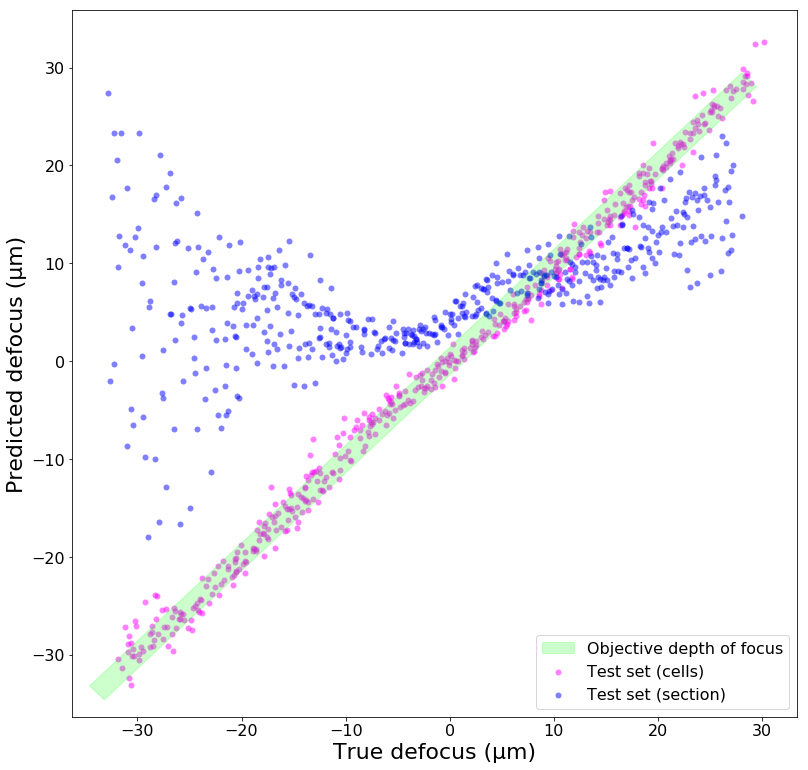

In [53]:
#use last 10% as validation set
validation_positions_section = [list(range(int(histology_data.get_num_xy_positions() * 0.1)))]

focal_planes = {histology_data: read_or_calc_focal_planes(histology_data, split_k=deterministic_params['tile_split_k'],
                n_cores=8, show_output=True)}

validation_features_section, validation_targets_section = compile_deterministic_data([histology_data], 
                        validation_positions_section, focal_planes, deterministic_params=deterministic_params)
val_generator_section = feature_vector_generator_fn(validation_features_section, validation_targets_section, mode='all', 
                                        split_k=deterministic_params['tile_split_k'])
with DefocusNetwork(deterministic_params=deterministic_params, input_shape=None, 
                    train_generator=None, train_mode='load', load_model_path='models/good_model') as network:
    test_prediction_defocus_histology, test_target_defocus_histoloy = network.predict(val_generator_section)

plt.figure(figsize=(13, 13))
plot_results(test_prediction_defocus, test_target_defocus, color=[1, 0, 1, 0.5])
plot_results(test_prediction_defocus_histology, test_target_defocus_histoloy, draw_rect=True, color=[0, 0, 1, 0.5])
plt.legend(['Objective depth of focus','Test set (cells)', 'Test set (section)'])
print('Cells RMSE: {}'.format( np.sqrt(np.mean((test_prediction_defocus - test_target_defocus) ** 2))))
print('Section RMSE: {}'.format( np.sqrt(np.mean((test_prediction_defocus_histology - 
                                                  test_target_defocus_histoloy) ** 2))))
if not os.path.isdir('figures'):
    os.mkdir('figures')
plt.savefig('figures/path_section_generalization.pdf', transparent=True)

## 2c) But finetuning the network with data from this type of sample can rescue performance
Does this damage performance on the orginal sample it was trained to predict?

In [54]:
finetune_positions_section =  list(range(int(histology_data.get_num_xy_positions() * 0.1),
                                         histology_data.get_num_xy_positions()))
finetune_positions_cells =  list(range(int(train_datasets[10].get_num_xy_positions() * 0.9)))

focal_planes = {dataset: read_or_calc_focal_planes(dataset, split_k=deterministic_params['tile_split_k'],
                n_cores=8, show_output=True) for dataset in [histology_data, train_datasets[10]]}

finetune_features, finetune_targets = compile_deterministic_data([histology_data, train_datasets[10]], 
    [finetune_positions_section, finetune_positions_cells], focal_planes, deterministic_params=deterministic_params)

finetune_generator = feature_vector_generator_fn(finetune_features, finetune_targets, mode='all', 
                                        split_k=deterministic_params['tile_split_k'])
#finetune and predict performance again
with DefocusNetwork(input_shape=finetune_features.shape[1], train_generator=finetune_generator,
                                val_generator=val_generator_section, predict_input_shape=[patch_size, patch_size],
                                deterministic_params=deterministic_params, train_mode='finetune', 
                                load_model_path='models/good_model', export_path='models/finetuned_model') as network:

    # run training set and both valdation sets through network to generate predictions
    section_prediction_defocus, section_target_defocus = network.predict(val_generator_section)
    cells_prediction_defocus, cells_target_defocus = network.predict(test_generator)

7748 sliceposition tuplesBuilding deterministic graph...
Evaluating deterministic graph over training set...


2186 sliceposition tuplesBuilding deterministic graph...
Evaluating deterministic graph over training set...
INFO:tensorflow:Restoring parameters from ./good_model/variables/variables
Building trainable graph...
INFO:tensorflow:Scale of 0 disables regularizer.
Building trainable graph...
INFO:tensorflow:Scale of 0 disables regularizer.
Building deterministic graph...
Building trainable graph...
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from ./good_model/variables/variables
Training model...
Step 0, val loss: 16.043825149536133
Step 25, val loss: 14.932939529418945
Step 50, val loss: 13.13886833190918
Step 75, val loss: 11.653099060058594
Step 100, val loss: 12.096189498901367
Step 125, val loss: 11.848902702331543
Step 150, val loss: 11.31770133972168
Step 175, val loss: 10.51943302154541
Step 200, val loss: 10.314955711364746
Step 225, val loss: 14.205790519714355
Step 250, val loss: 10.350654602050781
Step 275, val loss: 10.0375337600708
St

Step 4950, val loss: 4.550949573516846
Step 4975, val loss: 4.613007545471191
Step 5000, val loss: 4.552863597869873
Step 5025, val loss: 4.906689167022705
Step 5050, val loss: 4.706047058105469
Step 5075, val loss: 4.824302673339844
Step 5100, val loss: 4.698988437652588
Step 5125, val loss: 4.629418849945068
Step 5150, val loss: 4.563801288604736
Step 5175, val loss: 5.689177989959717
Step 5200, val loss: 4.742439270019531
Step 5225, val loss: 4.661982536315918
Step 5250, val loss: 4.693870544433594
Step 5275, val loss: 4.610585689544678
Step 5300, val loss: 5.099047660827637
Step 5325, val loss: 4.624845504760742
Step 5350, val loss: 4.7016801834106445
Step 5375, val loss: 4.608503818511963
Step 5400, val loss: 4.654044151306152
Step 5425, val loss: 4.672121524810791
Step 5450, val loss: 4.666152477264404
Step 5475, val loss: 4.6970343589782715
Step 5500, val loss: 4.759747505187988
Step 5525, val loss: 4.671126842498779
Step 5550, val loss: 4.612362384796143
Step 5575, val loss: 4.

Step 10200, val loss: 4.314263820648193
Step 10225, val loss: 4.287692070007324
Step 10250, val loss: 4.246298789978027
Step 10275, val loss: 4.204916477203369
Step 10300, val loss: 4.168666839599609
Step 10325, val loss: 4.176582336425781
Step 10350, val loss: 4.128849983215332
Step 10375, val loss: 4.216517448425293
Step 10400, val loss: 4.347967624664307
Step 10425, val loss: 4.790628433227539
Step 10450, val loss: 7.695333957672119
Step 10475, val loss: 4.259244441986084
Step 10500, val loss: 4.803400993347168
Step 10525, val loss: 4.274745464324951
Step 10550, val loss: 4.12216854095459
Step 10575, val loss: 4.206345081329346
Step 10600, val loss: 4.110466480255127
Step 10625, val loss: 4.9945149421691895
Step 10650, val loss: 4.4445366859436035
Step 10675, val loss: 4.40678596496582
Step 10700, val loss: 4.455448627471924
Step 10725, val loss: 4.624759197235107
Step 10750, val loss: 4.29893684387207
Step 10775, val loss: 4.665289402008057
Step 10800, val loss: 4.214384078979492
S

Step 15325, val loss: 4.024707794189453
Step 15350, val loss: 4.022524833679199
Step 15375, val loss: 4.06733512878418
Step 15400, val loss: 4.148579120635986
Step 15425, val loss: 4.1656575202941895
Step 15450, val loss: 4.0508623123168945
Step 15475, val loss: 4.293208122253418
Step 15500, val loss: 4.171700954437256
Step 15525, val loss: 4.224564075469971
Step 15550, val loss: 7.099165916442871
Step 15575, val loss: 4.153225421905518
Step 15600, val loss: 4.335111618041992
Step 15625, val loss: 4.043545246124268
Step 15650, val loss: 4.067546367645264
Step 15675, val loss: 3.889899492263794
Step 15700, val loss: 3.920661687850952
Step 15725, val loss: 3.8844168186187744
Step 15750, val loss: 3.965015172958374
Step 15775, val loss: 4.435659408569336
Step 15800, val loss: 3.7490975856781006
Step 15825, val loss: 5.373866558074951
Step 15850, val loss: 3.856670618057251
Step 15875, val loss: 3.8083574771881104
Step 15900, val loss: 3.8904807567596436
Step 15925, val loss: 4.37472391128

Cells RMSE: 1.7604521594977431
Section RMSE: 1.7521346113235996


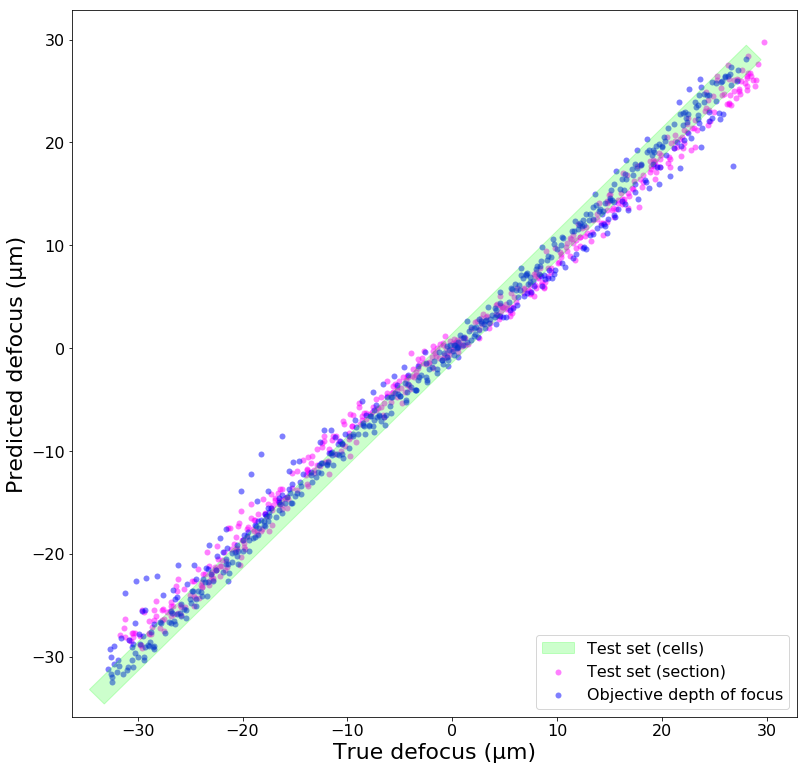

In [55]:
plt.figure(figsize=(13, 13))
plot_results(cells_prediction_defocus, cells_target_defocus, color=[1, 0, 1, 0.5])
plot_results(section_prediction_defocus, section_target_defocus, draw_rect=True, color=[0, 0, 1, 0.5])
plt.legend(['Objective depth of focus', 'Test set (cells)', 'Test set (section)'])
print('Cells RMSE: {}'.format( np.sqrt(np.mean((cells_prediction_defocus - cells_target_defocus) ** 2))))
print('Section RMSE: {}'.format( np.sqrt(np.mean((section_prediction_defocus - 
                                                  section_target_defocus) ** 2))))
if not os.path.isdir('figures'):
    os.mkdir('figures')
plt.savefig('figures/path_section_generalization_finetuned.pdf', transparent=True)

## 3) How does performance vary with amount of training data

In [3]:
deterministic_params = {'non_led_width': 0.1, 'led_width': 0.6, 'tile_split_k': 2}

# load data
train_datasets = [
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-8-26 Slide set 2 af training/Slide 2-0a 6x6 30um again_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-8-26 Slide set 2 af training/Slide 2-0c 6x6 30um again_1.hdf'),
    HDFDataWrapper('/media/hugespace/henry/data/deepaf2/2018-8-26 Slide set 2 af training/Slide 2-0c 6x6 30um_1.hdf'),
    HDFDataWrapper('/media/hugespace/henry/data/deepaf2/2018-8-26 Slide set 2 af training/Slide 2-0d 6x6 30um_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-8-26 Slide set 2 af training/Slide 2-0d 6x6 30um again_1.hdf'),
]

test_dataset = HDFDataWrapper(
    '/media/hugespace/henry/data/deepaf2/2018-8-26 Slide set 2 af training/Slide 2-0a 6x6 30um_1.hdf')


# load or compute target focal planes using 22 CPU cores to speed computation
focal_planes = {dataset: read_or_calc_focal_planes(dataset, split_k=deterministic_params['tile_split_k'],
                                     n_cores=22, show_output=True) for dataset in [*train_datasets, test_dataset]}

validation_positions = [list(range(int(dataset.get_num_xy_positions() * 0.9),
                                  dataset.get_num_xy_positions())) for dataset in train_datasets]
validation_features, validation_targets = compile_deterministic_data(train_datasets,
                                        validation_positions, focal_planes, deterministic_params=deterministic_params)
# test dataset is entirely different acquisition
test_features, test_targets = compile_deterministic_data([test_dataset],
         [list(range(test_dataset.get_num_xy_positions()))], focal_planes, deterministic_params=deterministic_params)

val_generator = feature_vector_generator_fn(validation_features, validation_targets, mode='all',
                                            split_k=deterministic_params['tile_split_k'])
test_generator = feature_vector_generator_fn(test_features, test_targets, mode='all',
                                             split_k=deterministic_params['tile_split_k'])

patch_size, patches_per_image = get_patch_metadata((test_dataset.get_image_width(),
                                      test_dataset.get_image_height()), deterministic_params['tile_split_k'])
num_positions = []
mses = []
for training_data_fraction in [0.05, 0.1, 0.2, 0.4, 0.8]:
    train_positions = [list(range(int(dataset.get_num_xy_positions() * 0.9 * training_data_fraction)))
                        for dataset in train_datasets]
    # Compute or load already computed design matrices
    train_features, train_targets = compile_deterministic_data(train_datasets, train_positions,
                                                               focal_planes, deterministic_params=deterministic_params)
    train_generator = feature_vector_generator_fn(train_features, train_targets, mode='all',
                                                  split_k=deterministic_params['tile_split_k'])

    if not os.path.isdir('models/data_fraction_model{}'.format(training_data_fraction)):
        # Create network and train it
        with DefocusNetwork(input_shape=train_features.shape[1], train_generator=train_generator,
                                val_generator=val_generator, predict_input_shape=[patch_size, patch_size],
                                deterministic_params=deterministic_params, train_mode='train',
                                export_path='models/data_fraction_model{}'.format(training_data_fraction)) as network:
            # run training set and both valdation sets through network to generate predictions
            # train_prediction_defocus, train_target_defocus = defocus_prediction_network.predict(train_generator)
            test_prediction_defocus, test_target_defocus = network.predict(test_generator)
    else:
        with DefocusNetwork(input_shape=train_features.shape[1], train_generator=train_generator,
                            val_generator=val_generator, predict_input_shape=[patch_size, patch_size],
                            deterministic_params=deterministic_params, train_mode='load',
                            load_model_path='models/data_fraction_model{}'.format(training_data_fraction)) as network:
            # run training set and both valdation sets through network to generate predictions
            # train_prediction_defocus, train_target_defocus = defocus_prediction_network.predict(train_generator)
            test_prediction_defocus, test_target_defocus = network.predict(val_generator)
        
    mses.append(np.sqrt(np.mean((test_prediction_defocus - test_target_defocus) ** 2)))
    num_positions.append(np.sum(np.array([len(l) for l in train_positions])))

244 sliceposition tuples

KeyboardInterrupt: 

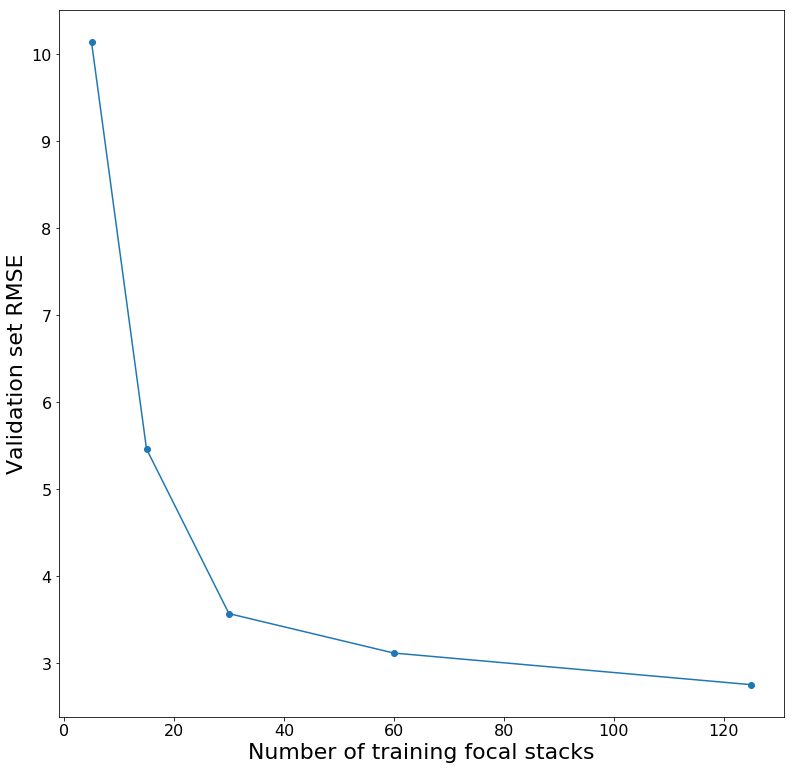

In [8]:
plt.figure(figsize=(13, 13))
plt.plot(num_positions, mses, 'o-')
plt.xlabel('Number of training focal stacks')
plt.ylabel('Validation set RMSE')

if not os.path.isdir('figures'):
    os.mkdir('figures')
plt.savefig('figures/training_data_dependence.pdf', transparent=True)

## 4) Illumination design
In this section we demonstrate why images with a single off-axis LED were chosen as the basis for autofocusing, by showing 1) single LED images perform better than multi-LED images and 2) the NA of a single LED affects network performance

The data used in this section consists of z-stacks, where at each z position, a series of images were taken with differnt LEDs with different NAs illuminating the sample. Multi-LED illuminations can be created computationally by adding the images from individual LED images, since different LEDs should be mutually incoherent and therefor their images will add in intensity on the sensor

In [12]:
class LEDDataWrapper(DataWrapper):
    
    def __init__(self, magellan, LED_indices):
        super().__init__(magellan)
        if LED_indices =='dpc':
            self.dpc = True
        else:
            self.led_indices = LED_indices
            self.dpc = False
        
    def read_prediction_image(self, position_index, z_index, patch_index, split_k):
        """
        Read image used for single shot prediction (i.e. single LED image)
        :param pos_index: index of xy position
        :param z_index: index of z slice (starting at 0)
        :param split_k: number of crops along each dimension
        :param patch_index: index of the crop
        :return:
        """
        patch_size, patches_per_image = get_patch_metadata((self.get_image_width(),
                                                            self.get_image_height()), split_k)
        y_tile_index = patch_index // split_k
        x_tile_index = patch_index % split_k
        xy_slice = [[y_tile_index * patch_size, (y_tile_index + 1) * patch_size],
                    [x_tile_index * patch_size, (x_tile_index + 1) * patch_size]]
        if self.dpc:
            image = self.magellan.read_image(channel_name='DPC_Bottom', pos_index=position_index, 
                    z_index=z_index + min(self.magellan.get_z_slices_at(position_index))).astype(np.float)
        else:
            image = None
            for led_index in self.led_indices:
                new_image = self.magellan.read_image(channel_name='led_{}'.format(led_index), pos_index=position_index, 
                    z_index=z_index + min(self.magellan.get_z_slices_at(position_index))).astype(np.float)
                if image is None:
                    image = new_image
                else:
                    image += new_image
            
        #crop
        return image[xy_slice[0][0]:xy_slice[0][1], xy_slice[1][0]:xy_slice[1][1]]
        
    
    #Ignore last xy posisiton in this dataset, since its acquisition was stopped in progress
    def get_num_xy_positions(self):
        return self.magellan.get_num_xy_positions() - 1

def compute_validation_rmse(data_wrapper, name, train_positions, validation_positions, deterministic_params):
    """
    Function for training network and calculating root mean square error on
    a validation set for different types of illumination
    :param pattern list of led indices to be used in illumination
    """
    if os.path.isdir('models/{}_model'.format(name)):
        print('loading features')
        validation_features, validation_targets = compile_deterministic_data([data_wrapper],
                                    [validation_positions], focal_planes, deterministic_params=deterministic_params)
        print('making generators')
        validation_generator = feature_vector_generator_fn(validation_features, validation_targets, mode='all',
                                                           split_k=deterministic_params['tile_split_k'])
        print('loading network')
        with DefocusNetwork(input_shape=validation_features.shape[1], train_generator=None,
                   predict_input_shape=[patch_size, patch_size], deterministic_params=deterministic_params, 
                   train_mode='load', load_model_path='models/{}_model'.format(name)) as network:
            print('predicting')
            # predict defocus on validation set
            predictions, targets = network.predict(validation_generator, consensus=True)
    else:
        print('loading features')
        train_features, train_targets = compile_deterministic_data([data_wrapper], [train_positions],
                               focal_planes, deterministic_params=deterministic_params)
        validation_features, validation_targets = compile_deterministic_data([data_wrapper],
                              [validation_positions], focal_planes, deterministic_params=deterministic_params)

        print('making generators')
        train_generator = feature_vector_generator_fn(train_features, train_targets, mode='all',
                                                      split_k=deterministic_params['tile_split_k'])
        validation_generator = feature_vector_generator_fn(validation_features, validation_targets, mode='all',
                                                           split_k=deterministic_params['tile_split_k'])
        print('training network')
        # Create network and train it
        with DefocusNetwork(input_shape=train_features.shape[1], train_generator=train_generator,
                                 val_generator=validation_generator, predict_input_shape=[patch_size, patch_size],
                                 deterministic_params=deterministic_params, train_mode='train',
                                    export_path='models/{}_model'.format(name)) as network:
            print('predicting')
            # predict defocus on validation set
            predictions, targets = network.predict(validation_generator, consensus=True)

    # compute rmse for each set of predictions
    return np.sqrt(np.mean((predictions - targets) ** 2))

## 4a) Different LED patterns

In [25]:
patterns = [[4], [119], [263],
            [11, 12], [11, 119], [119, 120], 
            [12, 119, 263], [12, 119, 120], [12, 120, 263],
            [82, 83, 84, 85], [12, 85, 187, 353], [12, 85, 188, 346], [12, 48, 119, 263],
            [4, 12, 28, 48, 83, 119, 187, 263, 351],
            [4, 13, 28, 49, 83, 121, 187, 265, 351],
            [4, 13, 27, 46, 83, 121, 188, 254, 351],
            [4, 5, 12, 13, 28, 29, 48, 49, 83, 85, 119, 121, 187, 189, 263, 265, 351, 353],
            [3, 4, 11, 12, 27, 28, 47, 48, 83, 84, 119, 120, 187, 188, 263, 264, 351, 352],
            'dpc']

#create data wrappers for each single LED    
data_source = MagellanWithAnnotation(
    '/media/hugespace/henry/data/deepaf2/2018-9-26 Single LED autofocus data/Orthogonal lines LEDs 30um range 1um step_1/')
data_wrappers = [LEDDataWrapper(data_source, pattern) for pattern in patterns]

deterministic_params = {'non_led_width': 1.0, 'led_width': 1.0, 'tile_split_k': 2}
patch_size, patches_per_image = get_patch_metadata((data_wrappers[0].get_image_width(),
                        data_wrappers[0].get_image_height()), deterministic_params['tile_split_k'])
focal_planes = {dataset: read_or_calc_focal_planes(dataset, split_k=deterministic_params['tile_split_k'],
                    n_cores=8, show_output=True) for dataset in data_wrappers}
num_pos = data_wrappers[0].get_num_xy_positions()

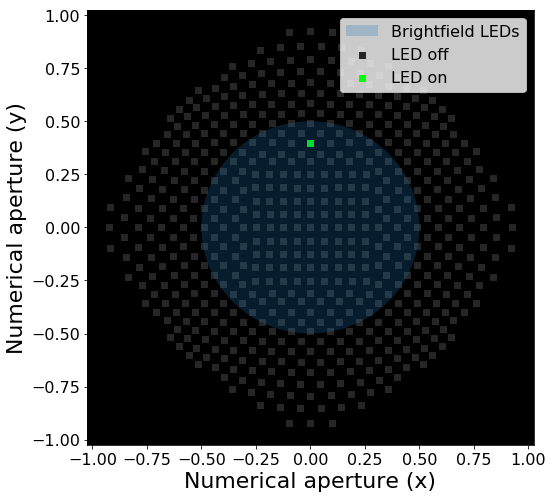

In [30]:
def plot_illumination(led_list, size=500):
    all_led_list = np.array([get_led_nas(led) for led in range(1, 582)])
    plt.scatter(all_led_list[:,0], all_led_list[:,1], size, marker=',', color=[0.15,0.15,0.15], 
                facecolor=None,edgecolor=None, edgecolors=None)
    plt.gca().set_facecolor([0,0,0])
    if led_list == 'dpc':
        led_list = [led for led in range(1, 581) 
            if (get_led_na(led) > 0.4 and get_led_na(led) < 0.5 and get_led_nas(led)[1] > 0)]
    for led in led_list:
        nax, nay = get_led_nas(led) 
        plt.scatter(nax, nay, size, marker='s', color=[0,1.0,0], 
                    facecolor=None, edgecolor=None, edgecolors=None)
    plt.gca().add_patch(plt.Circle((0, 0), 0.5, alpha=0.25))
    

#make an example plot
plt.figure(figsize=(8, 8))
plot_illumination([119],size=40)
plt.xlabel('Numerical aperture (x)')
plt.ylabel('Numerical aperture (y)')
plt.legend(['Brightfield LEDs','LED off','LED on'])
if not os.path.isdir('figures'):
    os.mkdir('figures')
plt.savefig('figures/LED_array_diagram.pdf')

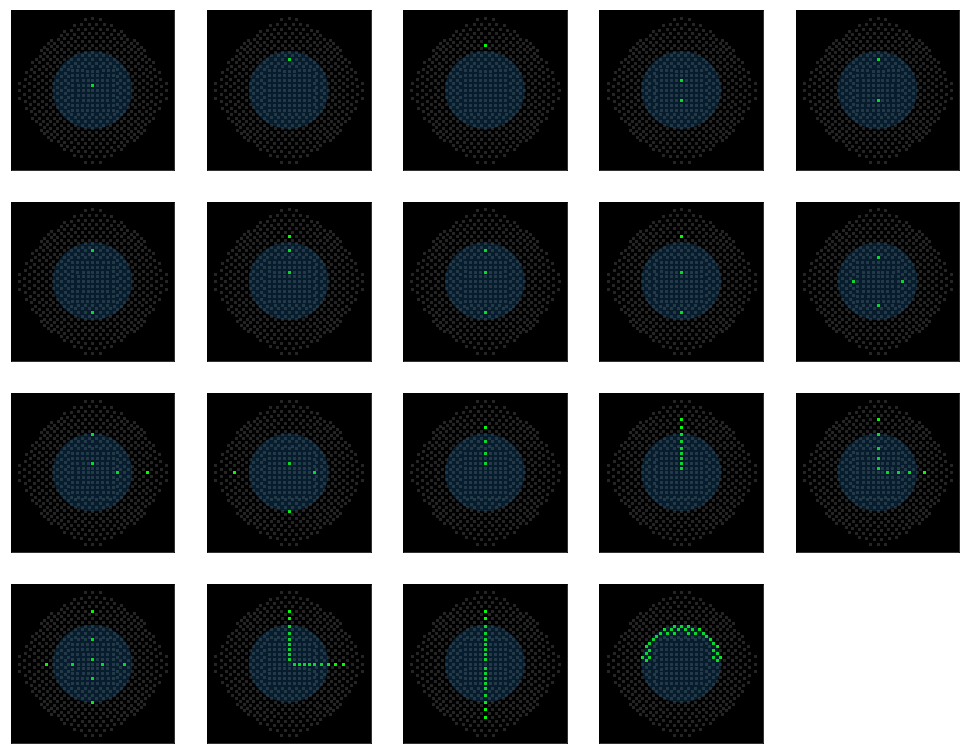

In [32]:
plt.figure(figsize=(17, 17))
for i, pattern in enumerate(patterns):
    plt.subplot(5, 5, i+1)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plot_illumination(pattern, size=6)

plt.savefig('figures/multiLED_illuminations.pdf')

Train network for each illumination and measure the root mean square error on validation set

In [26]:
rmses = []
for cross_val_index in range(8): 
    min_val_index = int(num_pos*(cross_val_index / 8))
    max_val_index = int(num_pos*((cross_val_index+1) / 8))
    train_positions = list(range(min_val_index)) + list(range(max_val_index, num_pos)) 
    validation_positions = list(range(min_val_index, max_val_index))

    rmse_cv = []
    for data_wrapper, pattern in zip(data_wrappers, patterns):
        pattern_name = '_'.join(map(str, pattern)) + '_cv{}'.format(cross_val_index)
        deterministic_params['illumination'] = pattern_name
        print('computing pattern {}'.format(pattern_name))
        rmse_cv.append(compute_validation_rmse(data_wrapper, pattern_name, train_positions,
                                            validation_positions, deterministic_params))
    rmses.append(rmse_cv)

computing pattern 4_cv0
loading features
making generators
loading network
INFO:tensorflow:Restoring parameters from models/4_cv0_model/variables/variables
predicting
computing pattern 119_cv0
loading features
making generators
loading network
INFO:tensorflow:Restoring parameters from models/119_cv0_model/variables/variables
predicting
computing pattern 263_cv0
loading features
making generators
loading network
INFO:tensorflow:Restoring parameters from models/263_cv0_model/variables/variables
predicting
computing pattern 11_12_cv0
loading features
making generators
loading network
INFO:tensorflow:Restoring parameters from models/11_12_cv0_model/variables/variables
predicting
computing pattern 11_119_cv0
loading features
making generators
loading network
INFO:tensorflow:Restoring parameters from models/11_119_cv0_model/variables/variables
predicting
computing pattern 119_120_cv0
loading features
making generators
loading network
INFO:tensorflow:Restoring parameters from models/119_120_c

predicting
computing pattern 11_119_cv2
loading features
making generators
loading network
INFO:tensorflow:Restoring parameters from models/11_119_cv2_model/variables/variables
predicting
computing pattern 119_120_cv2
loading features
making generators
loading network
INFO:tensorflow:Restoring parameters from models/119_120_cv2_model/variables/variables
predicting
computing pattern 12_119_263_cv2
loading features
making generators
loading network
INFO:tensorflow:Restoring parameters from models/12_119_263_cv2_model/variables/variables
predicting
computing pattern 12_119_120_cv2
loading features
making generators
loading network
INFO:tensorflow:Restoring parameters from models/12_119_120_cv2_model/variables/variables
predicting
computing pattern 12_120_263_cv2
loading features
making generators
loading network
INFO:tensorflow:Restoring parameters from models/12_120_263_cv2_model/variables/variables
predicting
computing pattern 82_83_84_85_cv2
loading features
making generators
loading n

Step 2550, val loss: 8.82261848449707
Step 2575, val loss: 6.058342933654785
Step 2600, val loss: 7.5665082931518555
Step 2625, val loss: 6.5002522468566895
Step 2650, val loss: 6.187543869018555
Step 2675, val loss: 6.558781623840332
Step 2700, val loss: 6.612337589263916
Step 2725, val loss: 6.288055419921875
Step 2750, val loss: 6.452077865600586
Step 2775, val loss: 6.761778354644775
Step 2800, val loss: 6.367123603820801
Step 2825, val loss: 6.355407238006592
Step 2850, val loss: 8.96407413482666
Step 2875, val loss: 11.3087797164917
Step 2900, val loss: 6.698914051055908
Step 2925, val loss: 7.384143352508545
Step 2950, val loss: 6.510046482086182
Step 2975, val loss: 6.215835094451904
Step 3000, val loss: 5.976409435272217
Step 3025, val loss: 6.473804950714111
Step 3050, val loss: 6.073668479919434
Step 3075, val loss: 7.330394744873047
Step 3100, val loss: 6.273025989532471
Step 3125, val loss: 6.542326927185059
Step 3150, val loss: 6.111776351928711
Step 3175, val loss: 7.336

KeyboardInterrupt: 

### Plot performance of different patterns and color by the number of LEDs

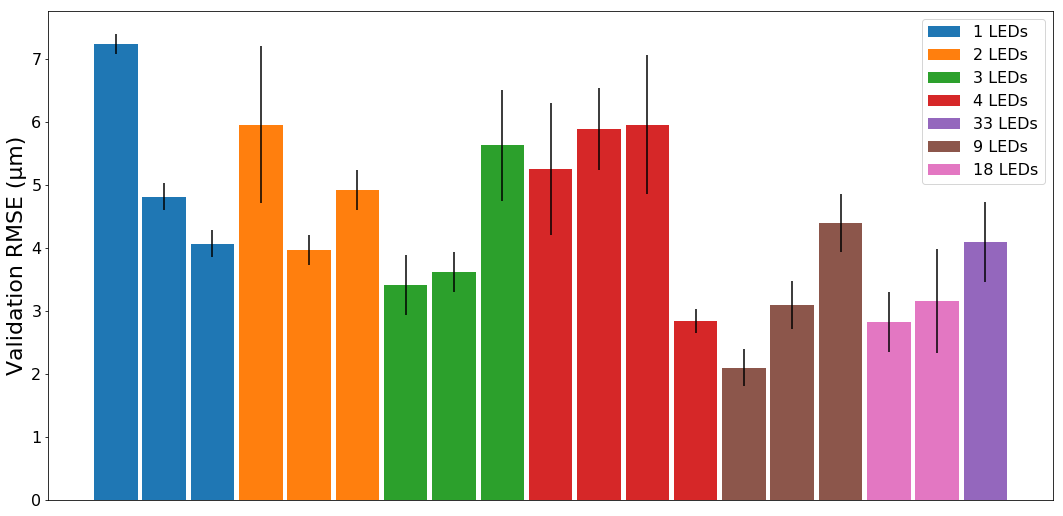

In [29]:
means = np.mean(rmses, axis=0)
stderr = np.std(np.array(rmses),axis=0) / np.sqrt(np.array(rmses).shape[0])
# print(means)
# print(stderr)

dpc_n_leds = len([led for led in range(1, 581) 
            if (get_led_na(led) > 0.4 and get_led_na(led) < 0.5 and get_led_nas(led)[1] > 0)])
n_leds = np.array([len(l) if l !='dpc' else dpc_n_leds for l in patterns])
color_map = {n_led: 'C{}'.format(i) for i, n_led in enumerate(set(n_leds))}
colors = [color_map[n_led] for n_led in n_leds]
plt.figure(figsize=(18, 9))
width = 0.9

indices = np.arange(np.size(means))
plots = []
for n_led in color_map.keys(): 
    p = plt.bar(indices[n_leds == n_led], means[n_leds == n_led], width, color=color_map[n_led], 
            yerr=stderr[n_leds == n_led])
    plots.append(p)
    
plt.legend(plots, ['{} LEDs'.format(nl) for nl in set(n_leds)])
    
plt.ylabel('Validation RMSE (µm)')
plt.gca().axes.get_xaxis().set_visible(False)
# plt.legend(n_leds)
# print((*n_leds))

if not os.path.isdir('figures'):
    os.mkdir('figures')
plt.savefig('figures/LED_patterns.pdf', transparent=True)

## 4b) What is the best numerical aperture of single LED illumination

In [14]:
#single led indices to use
patterns = [[4], [12], [28], [48], [83], [119], [187], [263], [351], [447], [555]]
numerical_apertures = [get_led_na(pattern[0]) for pattern in patterns]

#create data wrappers for each single LED
data_source = MagellanWithAnnotation(
    '/media/hugespace/henry/data/deepaf2/2018-9-26 Single LED autofocus data/Orthogonal lines LEDs 30um range 1um step_1/')
data_wrappers = [LEDDataWrapper(data_source, pattern) for pattern in patterns]
deterministic_params = {'non_led_width': 1.0, 'led_width': 1.0, 'tile_split_k': 2}
patch_size, patches_per_image = get_patch_metadata((data_wrappers[0].get_image_width(),
                        data_wrappers[0].get_image_height()), deterministic_params['tile_split_k'])
focal_planes = {dataset: read_or_calc_focal_planes(dataset, split_k=deterministic_params['tile_split_k'],
                    n_cores=22, show_output=True) for dataset in data_wrappers}
num_pos = data_wrappers[0].get_num_xy_positions()

In [8]:
rmses = []
for cross_val_index in range(8): 
    min_val_index = int(num_pos*(cross_val_index / 8))
    max_val_index = int(num_pos*((cross_val_index+1) / 8))
    train_positions = list(range(min_val_index)) + list(range(max_val_index, num_pos)) 
    validation_positions = list(range(min_val_index, max_val_index))
    rmse_cv = []
    for data_wrapper, pattern in zip(data_wrappers, patterns):
        pattern_name = '_'.join(map(str, pattern)) + '_cv{}'.format(cross_val_index)
        print('computing pattern {}'.format(pattern_name))
        deterministic_params['illumination'] = pattern_name
        rmse_cv.append(compute_validation_rmse(data_wrapper, pattern_name, train_positions, validation_positions,
                                              deterministic_params))
    rmses.append(rmse_cv)

computing pattern 4_cv0
loading features
making generators
loading network
INFO:tensorflow:Restoring parameters from models/4_cv0_model/variables/variables
predicting
computing pattern 12_cv0
loading features
making generators
loading network
INFO:tensorflow:Restoring parameters from models/12_cv0_model/variables/variables
predicting
computing pattern 28_cv0
loading features
making generators
loading network
INFO:tensorflow:Restoring parameters from models/28_cv0_model/variables/variables
predicting
computing pattern 48_cv0
loading features
making generators
loading network
INFO:tensorflow:Restoring parameters from models/48_cv0_model/variables/variables
predicting
computing pattern 83_cv0
loading features
making generators
loading network
INFO:tensorflow:Restoring parameters from models/83_cv0_model/variables/variables
predicting
computing pattern 119_cv0
loading features
making generators
loading network
INFO:tensorflow:Restoring parameters from models/119_cv0_model/variables/variabl

Step 1100, val loss: 8.274084091186523
Step 1125, val loss: 7.621870040893555
Step 1150, val loss: 7.635990619659424
Step 1175, val loss: 7.664921283721924
Step 1200, val loss: 7.378945350646973
Step 1225, val loss: 7.241176128387451
Step 1250, val loss: 8.028063774108887
Step 1275, val loss: 7.694602012634277
Step 1300, val loss: 8.058247566223145
Step 1325, val loss: 7.136721611022949
Step 1350, val loss: 7.000604152679443
Step 1375, val loss: 6.821842670440674
Step 1400, val loss: 7.055248260498047
Step 1425, val loss: 7.561728000640869
Step 1450, val loss: 7.173530101776123
Step 1475, val loss: 7.435754776000977
Step 1500, val loss: 7.291661262512207
Step 1525, val loss: 7.433762073516846
Step 1550, val loss: 7.0150041580200195
Step 1575, val loss: 7.116447448730469
Step 1600, val loss: 7.17203950881958
Step 1625, val loss: 7.651820182800293
Step 1650, val loss: 7.737194061279297
Step 1675, val loss: 8.240653991699219
Step 1700, val loss: 6.288634300231934
Step 1725, val loss: 7.54

Building trainable graph...
INFO:tensorflow:Scale of 0 disables regularizer.
Building deterministic graph...
Building trainable graph...
INFO:tensorflow:Scale of 0 disables regularizer.
Training model...
Step 0, val loss: 17.798189163208008
Step 25, val loss: 17.794958114624023
Step 50, val loss: 17.7904052734375
Step 75, val loss: 17.78417205810547
Step 100, val loss: 17.775039672851562
Step 125, val loss: 17.76211166381836
Step 150, val loss: 17.74056625366211
Step 175, val loss: 17.706790924072266
Step 200, val loss: 17.636985778808594
Step 225, val loss: 17.535037994384766
Step 250, val loss: 17.432065963745117
Step 275, val loss: 17.317508697509766
Step 300, val loss: 17.206140518188477
Step 325, val loss: 17.105989456176758
Step 350, val loss: 17.01388931274414
Step 375, val loss: 16.91596031188965
Step 400, val loss: 16.751352310180664
Step 425, val loss: 16.633581161499023
Step 450, val loss: 16.52524757385254
Step 475, val loss: 16.426559448242188
Step 500, val loss: 16.366006

Step 1650, val loss: 17.00128746032715
Step 1675, val loss: 17.00057029724121
Step 1700, val loss: 16.9964542388916
Step 1725, val loss: 16.9884033203125
Step 1750, val loss: 16.976911544799805
Step 1775, val loss: 16.981966018676758
Step 1800, val loss: 17.018476486206055
Step 1825, val loss: 17.017526626586914
Step 1850, val loss: 17.033313751220703
Step 1875, val loss: 17.03236961364746
Step 1900, val loss: 17.02859878540039
Step 1925, val loss: 17.032989501953125
Step 1950, val loss: 17.038108825683594
Step 1975, val loss: 17.025287628173828
Step 2000, val loss: 17.01008415222168
Step 2025, val loss: 17.00083351135254
Step 2050, val loss: 16.988513946533203
Step 2075, val loss: 16.979984283447266
Step 2100, val loss: 16.964746475219727
Step 2125, val loss: 16.985332489013672
Step 2150, val loss: 17.009132385253906
Step 2175, val loss: 17.01516342163086
Step 2200, val loss: 17.0229434967041
Step 2225, val loss: 17.013368606567383
Step 2250, val loss: 16.99543571472168
Step 2275, val

MemoryError: 

plot angle of LED vs validation RMSE

[[ 6.97507931  6.88813798  5.92602741  7.49141616  5.2389468   4.70862959
   6.07643308  4.25528638 14.37826337 16.60282095 14.0254769 ]
 [ 7.61934581  7.31090716  5.73703162  8.0417375   5.43811583  4.43076417
   5.19266253  3.55038786 13.45653716 16.75166712 13.72375222]
 [ 7.14099612  5.19275433  9.65333761  6.46071058  4.12886972  5.30987621
   5.17662043  4.3975819  13.82231393 16.5977217  12.85141091]]


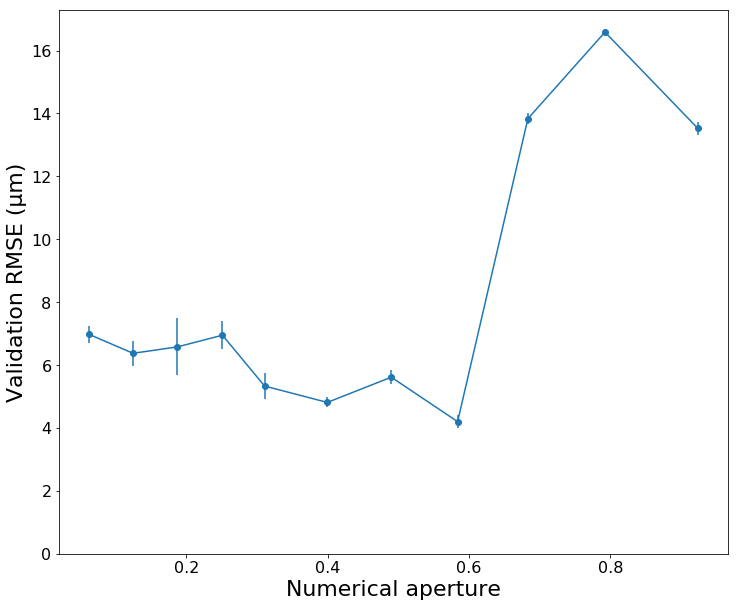

In [11]:
print(np.array(rmses[:3]))
angles = [get_led_angle(pattern[0]) for pattern in patterns]

plt.figure(figsize=(12,10))
plt.errorbar(numerical_apertures, np.mean(np.array(rmses),axis=0), yerr=np.std(np.array(rmses),axis=0) 
             / np.sqrt(np.array(rmses).shape[0]), fmt='o-')
# plt.plot(numerical_apertures, np.array(rmses).T, 'o-')

plt.xlabel('Numerical aperture')
plt.ylabel('Validation RMSE (µm)')
plt.ylim(bottom=0)

if not os.path.isdir('figures'):
    os.mkdir('figures')
plt.savefig('figures/na_dependence.pdf')

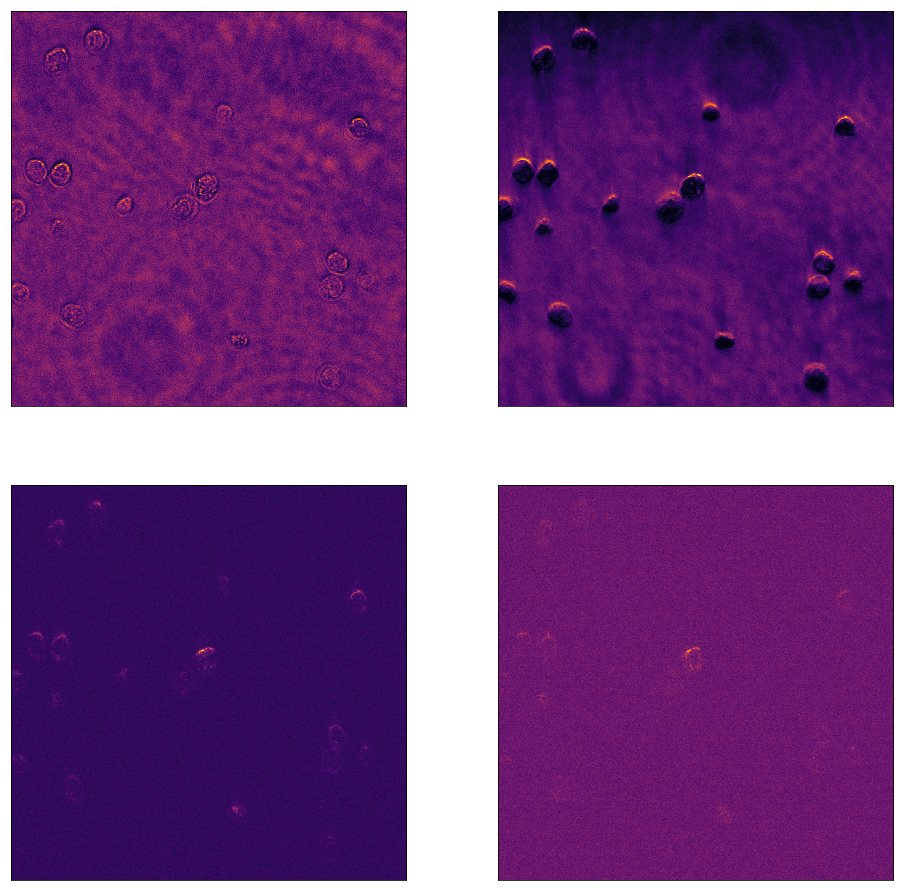

In [17]:
position_index = 2
z_index = 30
patch_index = 0
split_k = 2

plt.figure(figsize=(16, 16))
for i, data_index in enumerate([3,6,7,8]):
    plt.subplot(2,2,i+1)
    img = data_wrappers[data_index].read_prediction_image(position_index, z_index, patch_index, split_k)
    plt.imshow(img, cmap='inferno')
    savetiff('figures/single_led_img{}.tif'.format(i), img)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
if not os.path.isdir('figures'):
    os.mkdir('figures')
plt.savefig('figures/example_single_led_images.pdf')

## 5) Network that uses Fourier transform magnitude vs network that uses real part of Fourier Transform

In [3]:
data = DataWrapper(MagellanWithAnnotation(
    '/media/hugespace/henry/data/deepaf2/2018-9-27 Cells and histology af data/Neomounted cells 12x12 30um range 1um step_1'))
# compute focal planes
focal_planes = {dataset: read_or_calc_focal_planes(dataset, split_k=2,
                                                   n_cores=8, show_output=True) for dataset in [data]}

# split cell data into training and validation sets
num_pos = data.get_num_xy_positions()
train_positions = list(range(int(num_pos * 0.9)))
validation_positions = list(range(max(train_positions) + 1, num_pos))

In [ ]:
def train_and_test_performance(deterministic_params, name):
    # Compute or load already computed design matrices
    train_features, train_targets = compile_deterministic_data([data], [train_positions], focal_planes,
                                                               deterministic_params=deterministic_params)
    validation_features, validation_targets = compile_deterministic_data([data], [validation_positions],
                                                          focal_planes, deterministic_params=deterministic_params)
    train_generator = feature_vector_generator_fn(train_features, train_targets, mode='all',
                                                  split_k=deterministic_params['tile_split_k'])
    val_generator = feature_vector_generator_fn(validation_features, validation_targets, mode='all',
                                                split_k=deterministic_params['tile_split_k'])
    patch_size, patches_per_image = get_patch_metadata((data.get_image_width(),
                                                        data.get_image_height()), deterministic_params['tile_split_k'])
    # Create network and train it
    with DefocusNetwork(input_shape=train_features.shape[1], train_generator=train_generator,
                        val_generator=val_generator, predict_input_shape=[patch_size, patch_size],
                        deterministic_params=deterministic_params, train_mode='train', 
                        val_overshoot_steps=5000, load_model_path='models/{}_model'.format(name),
                        export_path='models/{}_model'.format(name)) as network:
        # run training set and both valdation sets through network to generate predictions
        train_prediction_defocus, train_target_defocus = network.predict(train_generator)
        val_prediction_defocus, val_target_defocus = network.predict(val_generator)
    return train_prediction_defocus, train_target_defocus, val_prediction_defocus, val_target_defocus


# test architectures that use magnitude and real part of fourier transform
deterministic_params = {'non_led_width': 0.1, 'led_width': 0.6, 'tile_split_k': 2}
train_pred_mag, train_target_mag, val_pred_mag, val_target_mag = train_and_test_performance(
                                                deterministic_params, 'magnitude')
deterministic_params = {'non_led_width': 0.1, 'led_width': 0.6, 'tile_split_k': 2, 'architecture': 'keep_it_phase'}
train_pred_phase, train_target_phase, val_pred_phase, val_target_phase = train_and_test_performance(
                                                    deterministic_params, 'keep_it_phase')

computing normalizations
Building trainable graph...
INFO:tensorflow:Scale of 0 disables regularizer.
Building trainable graph...
INFO:tensorflow:Scale of 0 disables regularizer.
Building deterministic graph...
Building trainable graph...
INFO:tensorflow:Scale of 0 disables regularizer.
Training model...
Step 0, val loss: 17.732927322387695
Step 25, val loss: 17.72300148010254
Step 50, val loss: 17.711170196533203
Step 75, val loss: 17.698396682739258
Step 100, val loss: 17.678449630737305
Step 125, val loss: 17.659191131591797
Step 150, val loss: 17.574785232543945
Step 175, val loss: 17.446208953857422
Step 200, val loss: 17.16944694519043
Step 225, val loss: 16.7802734375
Step 250, val loss: 16.037256240844727
Step 275, val loss: 15.135283470153809
Step 300, val loss: 14.276975631713867
Step 325, val loss: 13.433340072631836
Step 350, val loss: 12.900842666625977
Step 375, val loss: 12.437629699707031
Step 400, val loss: 12.16624927520752
Step 425, val loss: 11.519957542419434
Step 

In [ ]:
print('Train Magnitude RMSE: {}'.format( np.sqrt(np.mean((train_pred_mag - train_target_mag) ** 2))))
print('Validation Magnitude part RMSE: {}'.format(np.sqrt(np.mean((val_pred_mag - val_target_mag) ** 2))))
print('Train Phase RMSE: {}'.format(np.sqrt(np.mean((train_pred_phase - train_target_phase) ** 2))))
print('Validation Phase RMSE: {}'.format(np.sqrt(np.mean((val_pred_phase  - val_target_phase) ** 2))))

plt.figure(figsize=(20, 8))
plt.subplot(121)
plot_results(train_pred_mag, train_target_mag, color=[0, 0, 0, 0.5], range=[32,35])
plot_results(val_pred_mag, val_target_mag, draw_rect=True,color=[1, 0, 1, 0.5], range=[32,35])
plt.title('Fourier transform magnitude', fontsize=24)
plt.legend(['Sample thickness', 'Training', 'Validation'])

plt.subplot(122)
plot_results(train_pred_phase, train_target_phase, color=[0, 0, 0, 0.5], range=[32,35])
plot_results(val_pred_phase, val_target_phase, draw_rect=True, color=[1, 0, 1, 0.5], range=[32,35])
plt.title('Fourier transform phase', fontsize=24)
plt.legend(['Sample thickness (5 µm)','Training', 'Validation'])
if not os.path.isdir('figures'):
    os.mkdir('figures')
plt.savefig('figures/mag_vs_phase.pdf')

### Show images with random phase and random amplitude

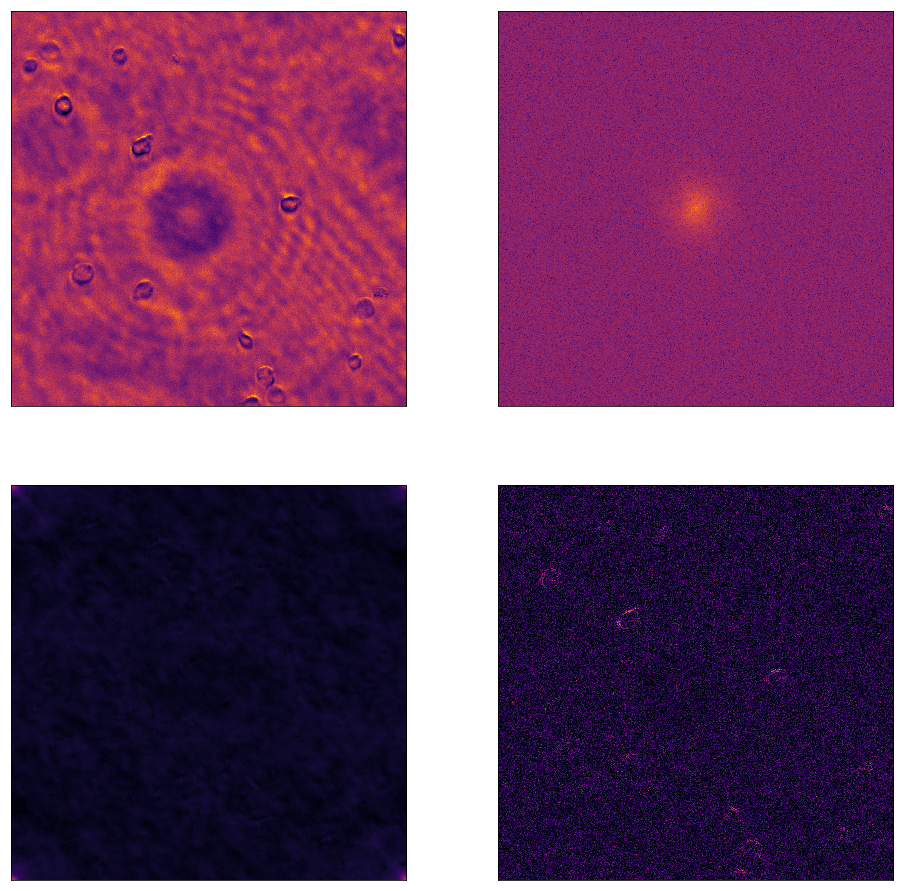

In [8]:
position_index = 2
z_index = 33
patch_index = 0
split_k = 2

image = data.read_prediction_image(position_index, z_index, patch_index, split_k)
image_ft = np.fft.fft2(image)

image_ft_mag = np.abs(image_ft)
image_ft_phase = image_ft / image_ft_mag
mag_vec = np.ravel(np.copy(image_ft_mag))
phase_vec = np.ravel(np.copy(image_ft_phase))
np.random.shuffle(mag_vec)
np.random.shuffle(phase_vec)
rand_phase = np.reshape(phase_vec, image.shape)
rand_mag = np.reshape(mag_vec, image.shape)

rand_phase_image = np.abs(np.fft.ifft2(np.exp(2j*3.14*np.random.rand(*image.shape)) *  image_ft_mag ))
rand_mag_image = np.abs(np.fft.ifft2( np.random.rand(*image.shape) * image_ft_phase) )

zero_phase_image = np.log(np.abs(np.fft.ifft2(image_ft_mag )))
uniform_mag_image = np.abs(np.fft.ifft2( image_ft_phase) )

plt.figure(figsize=(16, 16))
for i, image in enumerate([image, np.log(np.fft.fftshift(image_ft_mag)),
                           zero_phase_image, uniform_mag_image]):
    plt.subplot(2, 2 ,i+1)
    savetiff('figures/uniformfourier{}.tif'.format(i),image)
#     if i ==3:
#         plt.imshow(image, cmap='inferno',vmax=np.max(image)*0.6)
#     else:
    plt.imshow(image, cmap='inferno')
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)

if not os.path.isdir('figures'):
    os.mkdir('figures')
plt.savefig('figures/rand_phase_mag_images.pdf',transparent=True)

## 6) Show saliency map for what part of the image it pays attention to

In [7]:
#parameters for the deterministic part of the network
deterministic_params = {'non_led_width': 1.0, 'led_width': 1.0, 'tile_split_k': 2}

# load data
train_datasets = [
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-8-1 A bit more pre collection af/300k 7x7 30um range 50ms_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-8-1 A bit more pre collection af/75k 7x7 30um range 50ms_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-7-30 Pre collection autofocus/75k cells 10 ms exposure_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-7-30 Pre collection autofocus/75k cells 50 ms exposure_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-7-30 Pre collection autofocus/75k cells 150 ms exposure_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-7-30 Pre collection autofocus/300k cells 10 ms exposure_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-7-30 Pre collection autofocus/300k cells 50 ms exposure_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-7-30 Pre collection autofocus/300k cells 150 ms exposure_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-8-21 Slide 1-10/slide 1-10 seconds mid acquisition autofocus_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-8-21 Slide 1-10/slide 1-10 third mid acquisition autofocus_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-8-26 Slide set 2 af training/Slide 2-0a 6x6 30um again_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-8-26 Slide set 2 af training/Slide 2-0c 6x6 30um again_1.hdf'),
    HDFDataWrapper('/media/hugespace/henry/data/deepaf2/2018-8-26 Slide set 2 af training/Slide 2-0c 6x6 30um_1.hdf'),
    HDFDataWrapper('/media/hugespace/henry/data/deepaf2/2018-8-26 Slide set 2 af training/Slide 2-0d 6x6 30um_1.hdf'),
    HDFDataWrapper(
        '/media/hugespace/henry/data/deepaf2/2018-8-26 Slide set 2 af training/Slide 2-0d 6x6 30um again_1.hdf'),
]

focal_planes = {dataset: read_or_calc_focal_planes(dataset, split_k=deterministic_params['tile_split_k'],
                n_cores=8, show_output=True) for dataset in [*train_datasets, test_dataset]}

train_positions = [list(range(int(dataset.get_num_xy_positions() * 0.9))) for dataset in train_datasets]
validation_positions = [list(range(int(dataset.get_num_xy_positions() * 0.9),
                                  dataset.get_num_xy_positions())) for dataset in train_datasets]
# Compute or load already computed design matrices
train_features, train_targets = compile_deterministic_data(train_datasets, train_positions,
                           focal_planes, deterministic_params=deterministic_params, subfraction=0.7)
validation_features, validation_targets = compile_deterministic_data(train_datasets,
                           validation_positions, focal_planes, deterministic_params=deterministic_params)
train_generator = feature_vector_generator_fn(train_features, train_targets, mode='all',
                                              split_k=deterministic_params['tile_split_k'])
val_generator = feature_vector_generator_fn(validation_features, validation_targets, mode='all',
                                            split_k=deterministic_params['tile_split_k'])
 
patch_size, patches_per_image = get_patch_metadata((test_dataset.get_image_width(),
                                test_dataset.get_image_height()), deterministic_params['tile_split_k'])

KeyboardInterrupt: 

In [8]:
deterministic_params = {'non_led_width': 1.0, 'led_width': 1.0, 'tile_split_k': 2}

test_dataset = HDFDataWrapper(
    '/media/hugespace/henry/data/deepaf2/2018-8-26 Slide set 2 af training/Slide 2-0a 6x6 30um_1.hdf')
focal_planes = {test_dataset: read_or_calc_focal_planes(test_dataset, split_k=deterministic_params['tile_split_k'],
                n_cores=8, show_output=True)}

test_features, test_targets = compile_deterministic_data([test_dataset], 
        [list(range(test_dataset.get_num_xy_positions()))], focal_planes, deterministic_params=deterministic_params)
test_generator = feature_vector_generator_fn(test_features, test_targets, mode='all',
                                            split_k=deterministic_params['tile_split_k'])


In [9]:
# model_path = 'models/saliency_model_untrained'
# patch_size, patches_per_image = get_patch_metadata((test_dataset.get_image_width(),
#                                 test_dataset.get_image_height()), deterministic_params['tile_split_k'])

# # normalizations = {'mean': np.mean(train_features, axis=0), 'std': np.std(train_features, axis=0)}
# with DefocusNetwork(input_shape=test_features.shape[1], train_generator=train_generator,
#                                  val_generator=val_generator, predict_input_shape=[patch_size, patch_size],
#                                  deterministic_params=deterministic_params, train_mode='train',
#                              export_path=model_path, normalizations=normalizations, total_steps=0) as network:
#     gradients, targets = network.compute_gradients(test_generator)

# grads_untrained = np.stack(gradients)
    

model_path = 'models/saliency_model'
patch_size, patches_per_image = get_patch_metadata((test_dataset.get_image_width(),
                                test_dataset.get_image_height()), deterministic_params['tile_split_k'])
if os.path.isdir(model_path):
    with DefocusNetwork(input_shape=test_features.shape[1], train_generator=None,
                        predict_input_shape=[patch_size, patch_size],
                        deterministic_params=deterministic_params, train_mode='load',
                        load_model_path=model_path) as network:
        gradients, targets = network.compute_gradients(test_generator)
else:
    normalizations = {'mean': np.mean(train_features, axis=0), 'std': np.std(train_features, axis=0)}
    with DefocusNetwork(input_shape=test_features.shape[1], train_generator=train_generator,
                                 val_generator=val_generator, predict_input_shape=[patch_size, patch_size],
                                 deterministic_params=deterministic_params, train_mode='train',
                             export_path=model_path, normalizations=normalizations) as network:

        gradients, targets = network.compute_gradients(test_generator)

relu_grads = np.stack(gradients)
relu_targets = np.array(targets)

INFO:tensorflow:Restoring parameters from models/saliency_model/variables/variables


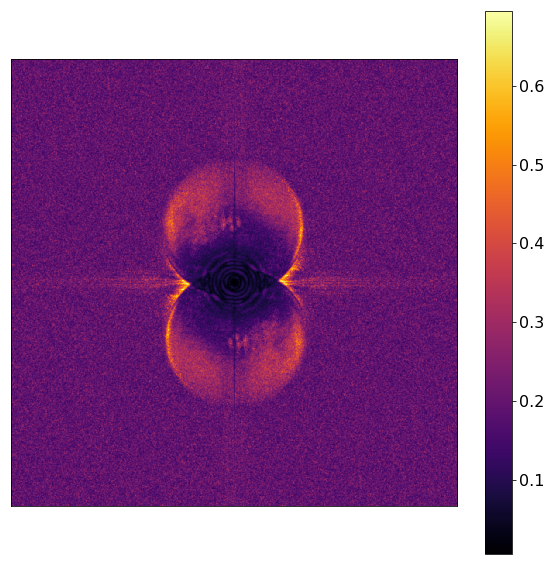

In [13]:
from skimage import filters

def recon_fft(spectrum):
    full = np.concatenate( [spectrum, np.flip(np.flip(np.copy(spectrum), axis=1), axis=0)], axis=1)
    return np.fft.ifftshift(full)

def filt(img):
    img_rescaled = img / np.max(np.abs(np.ravel(img)))
    filtered = filters.gaussian(img_rescaled, sigma=1)
    return filtered

def show_grad_image(min_defocus, max_defocus, function, grads, targets):
    show_image = filt(recon_fft(function(grads[np.logical_and(targets < max_defocus, targets > min_defocus)])))
    plt.imshow(show_image, cmap='inferno')
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    return show_image


grad_fn = lambda x : np.mean(np.abs(x), axis=0)

plt.figure(figsize=(10, 10))
img1 = show_grad_image(-30, 30, grad_fn, relu_grads, relu_targets)
plt.colorbar()

savetiff('figures/saliency_map.tif',img1)



# intervals = [[-25, -20], [20, 25], [-2.5, 2.5]]

# plt.figure(figsize=(17,17))
# plt.subplot(2,2,1)
# img1 = show_grad_image(*intervals[0], grad_fn, grads, targets)
# plt.title('{} um defocus'.format(np.mean(intervals[0])))
# plt.colorbar()

# plt.subplot(2,2,2)
# img2 = show_grad_image(*intervals[1], grad_fn, grads, targets)
# plt.title('{} um defocus'.format(np.mean(intervals[1])))

# plt.subplot(2,2,3)
# img3 = show_grad_image(*intervals[2], grad_fn, grads, targets)
# plt.title('{} um defocus'.format(np.mean(intervals[2])))
if not os.path.isdir('figures'):
    os.mkdir('figures')
plt.savefig('figures/saliency_map.pdf')

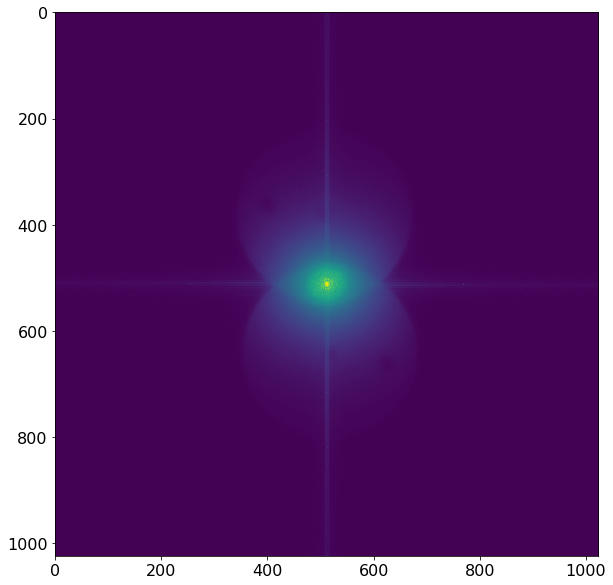

In [32]:
#show why those weird rings can appear--because they are present in the difference of magnitudes of images
input_fts = test_features.reshape((-1, 1024,512))

ftall = np.log(recon_fft(np.mean(input_fts,axis=0)))

# ft1 = np.log(recon_fft(np.mean(input_fts[np.logical_and(test_targets < 26, test_targets > 20)],axis=0)))
# ft2 = np.log(recon_fft(np.mean(input_fts[np.logical_and(test_targets < 25, test_targets > 15)], axis=0)))


plt.figure(figsize=(10, 10))
plt.imshow(ftall)
savetiff('figures/ftexample.tif',ftall)
# plt.imshow(ft2 - ft1)                        
      
